In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision
import torchvision.transforms.v2 as v2

import numpy as np
import pandas as pd
import math
from pathlib import Path
from collections import Counter
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.colors as mcolor
from itertools import chain, pairwise
import random
from tqdm import tqdm
import sys

from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
)

sys.path.append('./src')
from src.data import MultiSet, ImageTransforms, ProfileTransform, PairAugmentation
from src.profile_encoder import ProfileTransformer
from src.image_encoder import ImageEncoder
from src.model import MultiModel
from src.coordination import DistanceLoss, CLIPLoss, RankLoss
from src.zeroshot import ANNZeroShot

from lightning import Trainer
import logging

# from torch.utils.tensorboard import SummaryWriter
# from accelerate import Accelerator
# from accelerate.utils import GradientAccumulationPlugin

import scienceplots
plt.style.use('science')

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times"],
    "font.size": 12
})

# %matplotlib widget

import timm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import pacmap



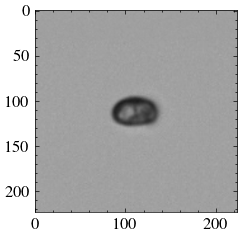

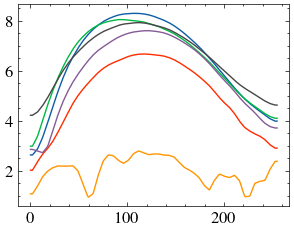

tensor(0.9406)

In [4]:
id = random.randint(0, len(test_set)-1)
data = test_set[id]

plt.imshow(data['image'].permute(1, 2, 0), cmap='gray', vmin=0, vmax=1)
plt.show()

plt.plot(data['profile'])
plt.show()

data['profile'].min()

In [31]:
annot = pd.read_csv(data_path / 'train.csv')
annot

,Unnamed: 0,ID,class_name
0,581,582,Aphanizomenon_flosaquae
1,643,644,Aphanizomenon_flosaquae
2,679,680,Aphanizomenon_flosaquae
3,492,493,Aphanizomenon_flosaquae
4,744,745,Aphanizomenon_flosaquae
...,...,...,...
6139,19317,19318,Tetraselmis_sp
6140,19284,19285,Tetraselmis_sp
6141,19325,19326,Tetraselmis_sp
6142,19509,19510,Tetraselmis_sp


In [66]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

for train, test in kfold.split(annot, annot.class_name):
    print(annot.iloc[test])


      Unnamed: 0     ID               class_name
21           793    794  Aphanizomenon_flosaquae
26           794    795  Aphanizomenon_flosaquae
29           184    185  Aphanizomenon_flosaquae
37           208    209  Aphanizomenon_flosaquae
38           520    521  Aphanizomenon_flosaquae
...          ...    ...                      ...
6106       19904  19905           Tetraselmis_sp
6109       19592  19593           Tetraselmis_sp
6111       20026  20027           Tetraselmis_sp
6116       19343  19344           Tetraselmis_sp
6137       19604  19605           Tetraselmis_sp

[1229 rows x 3 columns]
      Unnamed: 0     ID               class_name
1            643    644  Aphanizomenon_flosaquae
3            492    493  Aphanizomenon_flosaquae
8            832    833  Aphanizomenon_flosaquae
15           486    487  Aphanizomenon_flosaquae
19           425    426  Aphanizomenon_flosaquae
...          ...    ...                      ...
6129       19578  19579           Tetraselmi

In [17]:
annotation_id = 'fold1'
max_len = 256

data_path = Path('./data/FASTVISION-plus') / annotation_id

image_transforms = ImageTransforms()
signal_transforms = ProfileTransform(max_len=max_len)
pair_augmentation = PairAugmentation()

train_set = MultiSet(annotation_path=data_path / f'train.csv', 
                   image_transforms=image_transforms,
                   profile_transform=signal_transforms,
                   pair_augmentation=pair_augmentation)

test_set = MultiSet(annotation_path=data_path / f'test.csv', 
                    image_transforms=image_transforms,
                    profile_transform=signal_transforms,
                    pair_augmentation=None)


In [2]:
logging.getLogger("lightning.pytorch").setLevel(logging.ERROR)

names = (
    'efficientnet_b0_cnn_2_512_clip_FASTVISION-plus',
    'efficientnet_b0_cnn_2_512_siglip_FASTVISION-plus',
    'vit_s_16_transformer_2_512_clip_FASTVISION-plus',
    'vit_s_16_transformer_2_512_siglip_FASTVISION-plus',
)

data = {name: {} for name in names}

for name in names: 
    for i in range(1, 6):
        path = Path(f'logs/{name}_fold{i}/version_0/checkpoints')
        checkpoint = list(path.iterdir())[0]
        print(checkpoint)

        model = MultiModel.load_from_checkpoint(checkpoint)
        max_len = 256
        data_path = Path(f'./data/FASTVISION-plus/fold{i}')

        image_transforms = ImageTransforms()
        signal_transforms = ProfileTransform(max_len=max_len)
        pair_augmentation = PairAugmentation()

        test_set = MultiSet(annotation_path=data_path / f'test.csv', 
                            image_transforms=image_transforms,
                            profile_transform=signal_transforms,
                            pair_augmentation=None)

        def multi_collate(batch, model=model):
    
            image, profile, label, image_shape, profile_len = zip(*(sample.values() for sample in batch))
    
            image = {'image': torch.stack(image)}
            profile = model.profile_encoder.tokenize(profile)
            label = {'label': model.name_to_id(label)}
            image_shape = {'image_shape': torch.stack(image_shape)}
            profile_len = {'profile_len': torch.stack(profile_len)}
    
            return image | profile | label | image_shape | profile_len
    
        test_loader = DataLoader(dataset=test_set, batch_size=128, 
                                 num_workers=8, collate_fn=multi_collate)
    
        trainer = Trainer(barebones=True)
    
        test = trainer.predict(model, test_loader)
        image_test, profile_test, label_test = zip(*(sample.values() for sample in test))
    
        I_test = torch.cat(image_test).numpy()
        P_test = torch.cat(profile_test).numpy()
        L_test = torch.cat(label_test).numpy()

        data[name][i] = {
            'image': I_test,
            'profile': P_test,
            'label': L_test,
            'classes': model.label_encoder.classes_
        }

logs/efficientnet_b0_cnn_2_512_clip_FASTVISION-plus_fold1/version_0/checkpoints/epoch=88_valid_loss=0.59089.ckpt
logs/efficientnet_b0_cnn_2_512_clip_FASTVISION-plus_fold2/version_0/checkpoints/epoch=114_valid_loss=0.59132.ckpt
logs/efficientnet_b0_cnn_2_512_clip_FASTVISION-plus_fold3/version_0/checkpoints/epoch=84_valid_loss=0.57373.ckpt
logs/efficientnet_b0_cnn_2_512_clip_FASTVISION-plus_fold4/version_0/checkpoints/epoch=70_valid_loss=0.58677.ckpt
logs/efficientnet_b0_cnn_2_512_clip_FASTVISION-plus_fold5/version_0/checkpoints/epoch=75_valid_loss=0.60795.ckpt
logs/efficientnet_b0_cnn_2_512_siglip_FASTVISION-plus_fold1/version_0/checkpoints/epoch=26_valid_loss=2.24891.ckpt
logs/efficientnet_b0_cnn_2_512_siglip_FASTVISION-plus_fold2/version_0/checkpoints/epoch=55_valid_loss=2.14605.ckpt
logs/efficientnet_b0_cnn_2_512_siglip_FASTVISION-plus_fold3/version_0/checkpoints/epoch=60_valid_loss=2.22612.ckpt
logs/efficientnet_b0_cnn_2_512_siglip_FASTVISION-plus_fold4/version_0/checkpoints/epoch=9

/home/veikka/miniconda3/envs/dippa/lib/python3.12/site-packages/torch/nn/modules/transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


logs/vit_s_16_transformer_2_512_clip_FASTVISION-plus_fold2/version_0/checkpoints/epoch=49_valid_loss=1.00457.ckpt
logs/vit_s_16_transformer_2_512_clip_FASTVISION-plus_fold3/version_0/checkpoints/epoch=64_valid_loss=0.94487.ckpt
logs/vit_s_16_transformer_2_512_clip_FASTVISION-plus_fold4/version_0/checkpoints/epoch=39_valid_loss=0.97699.ckpt
logs/vit_s_16_transformer_2_512_clip_FASTVISION-plus_fold5/version_0/checkpoints/epoch=48_valid_loss=0.94705.ckpt
logs/vit_s_16_transformer_2_512_siglip_FASTVISION-plus_fold1/version_0/checkpoints/epoch=64_valid_loss=2.15046.ckpt
logs/vit_s_16_transformer_2_512_siglip_FASTVISION-plus_fold2/version_0/checkpoints/epoch=44_valid_loss=2.01601.ckpt
logs/vit_s_16_transformer_2_512_siglip_FASTVISION-plus_fold3/version_0/checkpoints/epoch=28_valid_loss=2.24892.ckpt
logs/vit_s_16_transformer_2_512_siglip_FASTVISION-plus_fold4/version_0/checkpoints/epoch=48_valid_loss=2.10851.ckpt
logs/vit_s_16_transformer_2_512_siglip_FASTVISION-plus_fold5/version_0/checkpoin

In [2]:
logging.getLogger("lightning.pytorch").setLevel(logging.ERROR)
names = (
    'efficientnet_b0_cnn_2_512_clip_FASTVISION-plus',
    'efficientnet_b0_cnn_2_512_siglip_FASTVISION-plus',
    'vit_s_16_transformer_2_512_clip_FASTVISION-plus',
    'vit_s_16_transformer_2_512_siglip_FASTVISION-plus',
)
K = (3, 15, 51, 101)

data = {name: {k: {'metrics': [], 'pred': []} for k in K} | {'true': []} for name in names}

for name in names: 
    for i in range(1, 6):
        path = Path(f'logs/{name}_fold{i}/version_0/checkpoints')
        checkpoint = list(path.iterdir())[0]
        print(checkpoint)

        model = MultiModel.load_from_checkpoint(checkpoint)
        max_len = 256
        data_path = Path(f'./data/FASTVISION-plus/fold{i}')

        image_transforms = ImageTransforms()
        signal_transforms = ProfileTransform(max_len=max_len)
        pair_augmentation = PairAugmentation()

        train_set = MultiSet(annotation_path=data_path / f'train.csv', 
                           image_transforms=image_transforms,
                           profile_transform=signal_transforms,
                           pair_augmentation=pair_augmentation)

        test_set = MultiSet(annotation_path=data_path / f'test.csv', 
                            image_transforms=image_transforms,
                            profile_transform=signal_transforms,
                            pair_augmentation=None)

        def multi_collate(batch, model=model):
    
            image, profile, label, image_shape, profile_len = zip(*(sample.values() for sample in batch))
    
            image = {'image': torch.stack(image)}
            profile = model.profile_encoder.tokenize(profile)
            label = {'label': model.name_to_id(label)}
            image_shape = {'image_shape': torch.stack(image_shape)}
            profile_len = {'profile_len': torch.stack(profile_len)}
    
            return image | profile | label | image_shape | profile_len
    
        train_loader = DataLoader(dataset=train_set, batch_size=128, 
                                  num_workers=8, collate_fn=multi_collate)
    
        test_loader = DataLoader(dataset=test_set, batch_size=128, 
                                 num_workers=8, collate_fn=multi_collate)
    
        trainer = Trainer(barebones=True)
    
        train = trainer.predict(model, train_loader)
        image_train, profile_train, label_train = zip(*(sample.values() for sample in train))
    
        test = trainer.predict(model, test_loader)
        image_test, profile_test, label_test = zip(*(sample.values() for sample in test))

        I_train = torch.cat(image_train).numpy()
        P_train  = torch.cat(profile_train).numpy()
        L_train = torch.cat(label_train).numpy()
    
        I_test = torch.cat(image_test).numpy()
        P_test  = torch.cat(profile_test).numpy()
        L_test = torch.cat(label_test).numpy()
        data[name]['true'].append(L_test)

        X = np.concatenate((I_train, P_train))
        y = np.tile(L_train, (2,))
    
        predictor = ANNZeroShot(X, y, n_neighbors=128, metric='cosine', diversify_prob=0.0, pruning_degree_multiplier=3.0)
        for k in K:
            pred = predictor.predict(I_test, P_test, k=k, epsilon=0.2)
            acc = accuracy_score(L_test, pred)
            metrics = precision_recall_fscore_support(L_test, pred, average='macro')
            data[name][k]['pred'].append(pred)
            data[name][k]['metrics'].append((acc,) + metrics[:-1])


logs/efficientnet_b0_cnn_2_512_clip_FASTVISION-plus_fold1/version_0/checkpoints/epoch=88_valid_loss=0.59089.ckpt
logs/efficientnet_b0_cnn_2_512_clip_FASTVISION-plus_fold2/version_0/checkpoints/epoch=114_valid_loss=0.59132.ckpt
logs/efficientnet_b0_cnn_2_512_clip_FASTVISION-plus_fold3/version_0/checkpoints/epoch=84_valid_loss=0.57373.ckpt
logs/efficientnet_b0_cnn_2_512_clip_FASTVISION-plus_fold4/version_0/checkpoints/epoch=70_valid_loss=0.58677.ckpt
logs/efficientnet_b0_cnn_2_512_clip_FASTVISION-plus_fold5/version_0/checkpoints/epoch=75_valid_loss=0.60795.ckpt
logs/efficientnet_b0_cnn_2_512_siglip_FASTVISION-plus_fold1/version_0/checkpoints/epoch=26_valid_loss=2.24891.ckpt
logs/efficientnet_b0_cnn_2_512_siglip_FASTVISION-plus_fold2/version_0/checkpoints/epoch=55_valid_loss=2.14605.ckpt
logs/efficientnet_b0_cnn_2_512_siglip_FASTVISION-plus_fold3/version_0/checkpoints/epoch=60_valid_loss=2.22612.ckpt
logs/efficientnet_b0_cnn_2_512_siglip_FASTVISION-plus_fold4/version_0/checkpoints/epoch=9

/home/veikka/miniconda3/envs/dippa/lib/python3.12/site-packages/torch/nn/modules/transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


logs/vit_s_16_transformer_2_512_clip_FASTVISION-plus_fold2/version_0/checkpoints/epoch=49_valid_loss=1.00457.ckpt
logs/vit_s_16_transformer_2_512_clip_FASTVISION-plus_fold3/version_0/checkpoints/epoch=64_valid_loss=0.94487.ckpt
logs/vit_s_16_transformer_2_512_clip_FASTVISION-plus_fold4/version_0/checkpoints/epoch=39_valid_loss=0.97699.ckpt
logs/vit_s_16_transformer_2_512_clip_FASTVISION-plus_fold5/version_0/checkpoints/epoch=48_valid_loss=0.94705.ckpt
logs/vit_s_16_transformer_2_512_siglip_FASTVISION-plus_fold1/version_0/checkpoints/epoch=64_valid_loss=2.15046.ckpt
logs/vit_s_16_transformer_2_512_siglip_FASTVISION-plus_fold2/version_0/checkpoints/epoch=44_valid_loss=2.01601.ckpt
logs/vit_s_16_transformer_2_512_siglip_FASTVISION-plus_fold3/version_0/checkpoints/epoch=28_valid_loss=2.24892.ckpt
logs/vit_s_16_transformer_2_512_siglip_FASTVISION-plus_fold4/version_0/checkpoints/epoch=48_valid_loss=2.10851.ckpt
logs/vit_s_16_transformer_2_512_siglip_FASTVISION-plus_fold5/version_0/checkpoin

In [3]:
data

{'efficientnet_b0_cnn_2_512_clip_FASTVISION-plus': {1: {'image': array([[ 0.0317085 , -0.23455897,  0.07967375, ..., -0.28128147,
           -0.39989784, -0.09984748],
          [ 0.14608979,  0.06185575,  0.10575669, ..., -0.16968529,
           -0.21520142, -0.33597586],
          [ 0.18870847, -0.4590986 , -0.09515837, ..., -0.42474335,
           -0.36995122,  0.09938814],
          ...,
          [ 0.21641591, -0.07516948,  0.06226297, ..., -0.20057687,
           -0.68243706,  0.20674503],
          [ 0.05649024, -0.20148554,  0.06941084, ..., -0.21882989,
           -0.6018718 ,  0.22499916],
          [ 0.14207733, -0.01734211,  0.07813029, ...,  0.37932363,
           -0.09551607,  0.27332732]], dtype=float32),
   'profile': array([[ 0.42457733, -0.09883937,  0.19732626, ..., -2.2495837 ,
           -0.96266425, -1.002981  ],
          [ 0.5132141 ,  0.7950335 ,  0.5471053 , ..., -1.8775508 ,
           -0.0600583 , -2.1743848 ],
          [ 0.23193721, -1.4042572 , -0.0212897

In [4]:
import pickle

with open('data.pkl', 'wb') as buf:
    pickle.dump(data, buf)

In [6]:
with open('embeddings.pkl', 'rb') as buf:
    data = pickle.load(buf)

data

{'efficientnet_b0_cnn_2_512_clip_FASTVISION-plus': {1: {'image': array([[ 0.0317085 , -0.23455897,  0.07967375, ..., -0.28128147,
           -0.39989784, -0.09984748],
          [ 0.14608979,  0.06185575,  0.10575669, ..., -0.16968529,
           -0.21520142, -0.33597586],
          [ 0.18870847, -0.4590986 , -0.09515837, ..., -0.42474335,
           -0.36995122,  0.09938814],
          ...,
          [ 0.21641591, -0.07516948,  0.06226297, ..., -0.20057687,
           -0.68243706,  0.20674503],
          [ 0.05649024, -0.20148554,  0.06941084, ..., -0.21882989,
           -0.6018718 ,  0.22499916],
          [ 0.14207733, -0.01734211,  0.07813029, ...,  0.37932363,
           -0.09551607,  0.27332732]], dtype=float32),
   'profile': array([[ 0.42457733, -0.09883937,  0.19732626, ..., -2.2495837 ,
           -0.96266425, -1.002981  ],
          [ 0.5132141 ,  0.7950335 ,  0.5471053 , ..., -1.8775508 ,
           -0.0600583 , -2.1743848 ],
          [ 0.23193721, -1.4042572 , -0.0212897

In [23]:
for name in names:
    true = data[name]['true']
    print(f'{name}:')
    for k in K:
        metrics = data[name][k]['metrics']
        mu = np.mean(metrics, 0)
        std = np.std(metrics, 0)
        vals = chain(*zip(mu, std))
        print(f'k={k:3d}' + (' {:.2%}' * 8).format(*vals))
    print()
        

efficientnet_b0_cnn_2_512_clip_FASTVISION-plus:
k=  3 98.85% 0.15% 98.79% 0.14% 98.73% 0.16% 98.75% 0.15%
k= 15 98.66% 0.08% 98.62% 0.08% 98.52% 0.09% 98.55% 0.08%
k= 51 98.17% 0.16% 98.11% 0.14% 97.97% 0.17% 98.01% 0.16%
k=101 97.72% 0.26% 97.67% 0.23% 97.46% 0.28% 97.53% 0.25%

efficientnet_b0_cnn_2_512_siglip_FASTVISION-plus:
k=  3 98.62% 0.31% 98.52% 0.36% 98.48% 0.34% 98.49% 0.35%
k= 15 98.56% 0.34% 98.49% 0.34% 98.42% 0.36% 98.43% 0.37%
k= 51 98.13% 0.48% 98.06% 0.49% 97.95% 0.52% 97.97% 0.52%
k=101 97.68% 0.64% 97.60% 0.63% 97.44% 0.71% 97.48% 0.70%

vit_s_16_transformer_2_512_clip_FASTVISION-plus:
k=  3 98.35% 0.16% 98.27% 0.15% 98.17% 0.18% 98.20% 0.17%
k= 15 98.42% 0.26% 98.38% 0.23% 98.23% 0.30% 98.29% 0.27%
k= 51 98.04% 0.24% 98.03% 0.21% 97.79% 0.28% 97.88% 0.25%
k=101 97.76% 0.27% 97.76% 0.25% 97.45% 0.33% 97.56% 0.30%

vit_s_16_transformer_2_512_siglip_FASTVISION-plus:
k=  3 97.89% 0.36% 97.81% 0.37% 97.68% 0.38% 97.72% 0.38%
k= 15 98.02% 0.36% 97.98% 0.34% 97.80% 0.40% 

In [ ]:
best = (3, 3, 3, 15)
labels = 
for k, name in zip(best, names):
    true

[array([ 0,  0,  0, ..., 23, 23, 23]), array([ 0,  0,  0, ..., 23, 23, 23]), array([ 0,  0,  0, ..., 23, 23, 23]), array([ 0,  0,  0, ..., 23, 23, 23]), array([ 0,  0,  0, ..., 23, 23, 23])]
[array([ 0,  0,  0, ..., 23, 23, 23]), array([ 0,  0,  0, ..., 23, 23, 23]), array([ 0,  0,  0, ..., 23, 23, 23]), array([ 0,  0,  0, ..., 23, 23, 23]), array([ 0,  0,  0, ..., 23, 23, 23])]
[array([ 0,  0,  0, ..., 23, 23, 23]), array([ 0,  0,  0, ..., 23, 23, 23]), array([ 0,  0,  0, ..., 23, 23, 23]), array([ 0,  0,  0, ..., 23, 23, 23]), array([ 0,  0,  0, ..., 23, 23, 23])]
[array([ 0,  0,  0, ..., 23, 23, 23]), array([ 0,  0,  0, ..., 23, 23, 23]), array([ 0,  0,  0, ..., 23, 23, 23]), array([ 0,  0,  0, ..., 23, 23, 23]), array([ 0,  0,  0, ..., 23, 23, 23])]


In [ ]:
# model = MultiModel.load_from_checkpoint('./logs/efficientnet_b0_cnn_1_unsupervised_128_FASTVISION-plus_fold1/version_0/checkpoints/epoch=80_valid_loss=0.85036.ckpt')
# model = MultiModel.load_from_checkpoint('./logs/CLIP_ef0_cnn1_FASTVISION-plus_fold1/version_9/checkpoints/epoch=67_valid_loss=0.83432.ckpt')
# model = MultiModel.load_from_checkpoint('./logs/CLIP_ef0_cnn2_FASTVISION-plus_fold1/version_2/checkpoints/epoch=82_valid_loss=0.81728.ckpt')
model = MultiModel.load_from_checkpoint(checkpoint)


def multi_collate(batch, model=model):

    image, profile, label, image_shape, profile_len = zip(*(sample.values() for sample in batch))

    image = {'image': torch.stack(image)}
    profile = model.profile_encoder.tokenize(profile)
    label = {'label': model.name_to_id(label)}
    image_shape = {'image_shape': torch.stack(image_shape)}
    profile_len = {'profile_len': torch.stack(profile_len)}

    return image | profile | label | image_shape | profile_len

train_loader = DataLoader(dataset=train_set, batch_size=128, 
                          num_workers=8, collate_fn=multi_collate)

test_loader = DataLoader(dataset=test_set, batch_size=128, 
                         num_workers=8, collate_fn=multi_collate)

trainer = Trainer()

train = trainer.predict(model, train_loader)
image_train, profile_train, label_train = zip(*(sample.values() for sample in train))

test = trainer.predict(model, test_loader)
image_test, profile_test, label_test = zip(*(sample.values() for sample in test))

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [19]:
I_train = torch.cat(image_train).numpy()
P_train  = torch.cat(profile_train).numpy()
L_train = torch.cat(label_train).numpy()

I_test = torch.cat(image_test).numpy()
P_test  = torch.cat(profile_test).numpy()
L_test = torch.cat(label_test).numpy()

In [20]:
X = np.concatenate((I_train, P_train))
y = np.tile(L_train, (2,))

predictor = ANNZeroShot(X, y, n_neighbors=128, metric='cosine', diversify_prob=0.0, pruning_degree_multiplier=3.0)

In [27]:
pred = predictor.predict(I_test, P_test, k=9, epsilon=0.2)

(pred == L_test).mean()

np.float64(0.985785536159601)

In [ ]:
index = NNDescent(
    data,
    n_neighbors=64,
    metric='cosine',
    diversify_prob=0.,
    pruning_degree_multiplier=3.
)
index.prepare()

In [17]:
%matplotlib qt

In [10]:
I_e = torch.cat(image_emb).numpy()
P_e = torch.cat(profile_emb).numpy()
# I_e /= np.linalg.norm(I_e, axis=1, keepdims=True)
# P_e /= np.linalg.norm(P_e, axis=1, keepdims=True)
L = torch.cat(label).numpy()

Et = np.concat((I_e, P_e))
Lt = np.tile(L, (2,))

# plt.hist(np.linalg.norm(I_e, axis=1), alpha=0.5)
# plt.hist(np.linalg.norm(P_e, axis=1), alpha=0.5)

mapping = pacmap.PaCMAP(n_components=2, n_neighbors=3, MN_ratio=.5) 
# mapping = TSNE(2)
reduced = mapping.fit_transform(Et)

TypeError: cat(): argument 'tensors' (position 1) must be tuple of Tensors, not numpy.ndarray

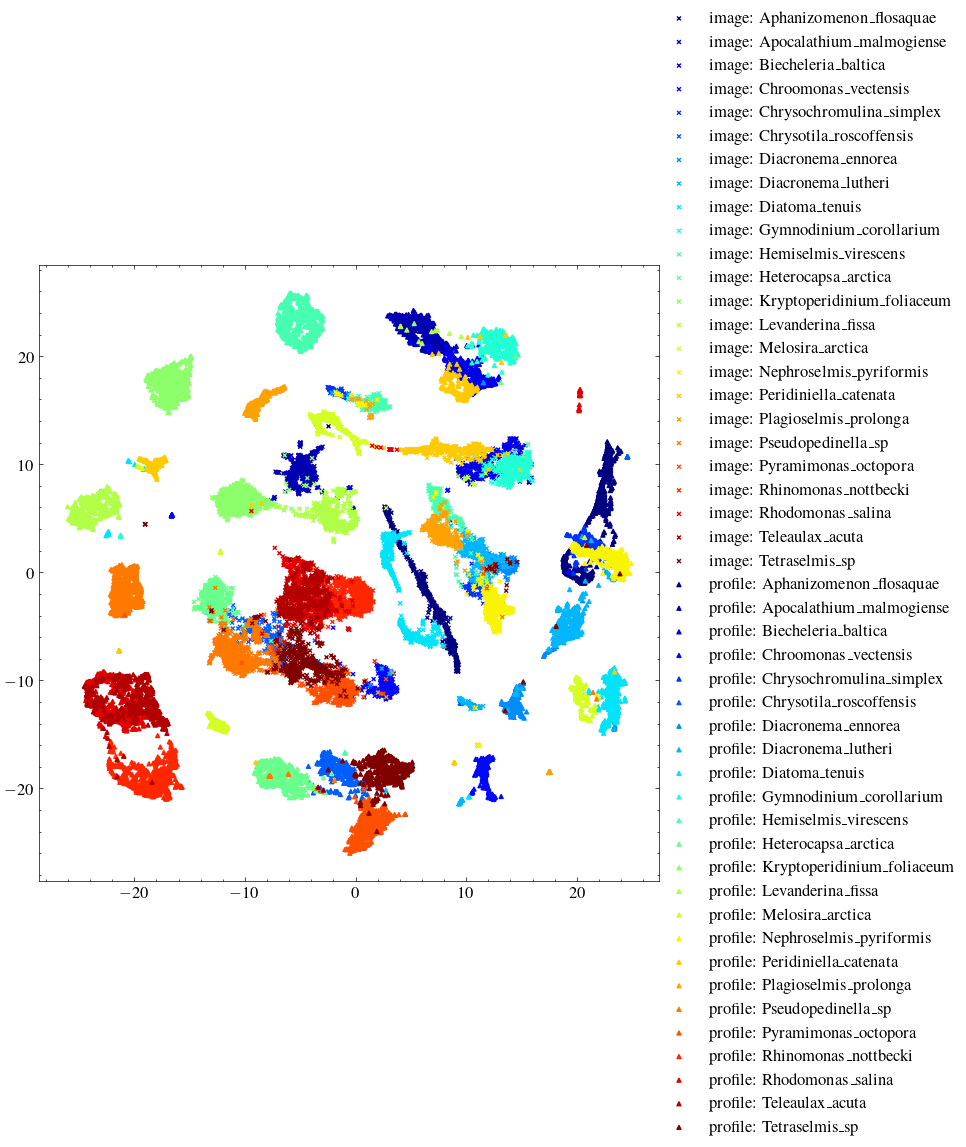

In [12]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.get_cmap(name, n)

fig = plt.figure()
ax = fig.add_subplot()

cmap = get_cmap(len(model.label_encoder.classes_), 'jet')

n = 22
for y in np.unique(Lt)[:]:
    class_name = model.label_encoder.inverse_transform([y])[0]
    e = reduced[:len(Lt)//2][Lt[:len(Lt)//2] == y]
    ax.scatter(*zip(*e), label=f'image: {class_name}', s=8, c=(cmap(y),)*len(e), marker='x')

for y in np.unique(Lt)[:]:
    class_name = model.label_encoder.inverse_transform([y])[0]
    e = reduced[len(Lt)//2:][Lt[len(Lt)//2:] == y]
    ax.scatter(*zip(*e), label=f'profile: {class_name}', s=8, c=(cmap(y),)*len(e), marker='^')

fig.set_size_inches(8, 8)
ax.legend(loc=7, bbox_to_anchor=(1.5, .5))
plt.show()

In [24]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=51, metric='cosine').fit(I_e, L)


prob = knn.predict_proba(P_e)

pred = prob.argmax(1)

(pred == L).mean()

np.float64(0.9402416223213002)

In [28]:
print(*model.loss.parameters())

Parameter containing:
tensor(3.0942, requires_grad=True) Parameter containing:
tensor(-10.0596, requires_grad=True)


In [113]:
I_e = torch.cat(image_emb).numpy()
P_e = torch.cat(profile_emb).numpy()
# I_e /= np.linalg.norm(I_e, axis=1, keepdims=True)
# P_e /= np.linalg.norm(P_e, axis=1, keepdims=True)
L = torch.cat(label).numpy()

Et = np.concat((I_e, P_e))
Lt = np.tile(L, (2,))

# Et = I_e.copy()
# Lt = L.copy()

In [114]:
np.linalg.norm(I_e, axis=1).mean(), np.linalg.norm(P_e, axis=1).mean()

(np.float32(5.6273847), np.float32(16.30003))

In [96]:

logits = (I_e / np.linalg.norm(I_e, axis=1, keepdims=True)) @ (P_e / np.linalg.norm(P_e, axis=1, keepdims=True)).T

(L[logits.argmax(1)] == L).mean()

np.float64(0.7950524953257586)

In [ ]:

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3, metric='cosine').fit(I_e, L)


prob = knn.predict_proba(P_e)

pred = prob.argmax(1)

(pred == L).mean()

np.float64(0.8586221774773479)

In [ ]:
from sklearn.metrics import top_k_accuracy_score

print(*map(float, [top_k_accuracy_score(L, prob, k=k) for k in range(1, 6)]))

[np.float64(0.862073924924493), np.float64(0.9376528117359413), np.float64(0.9513159787142241), np.float64(0.9565655112900906), np.float64(0.957356536746728)]


In [99]:
reduced = TSNE(2, perplexity=10, early_exaggeration=20).fit_transform(Et)

In [61]:
list(map(float, cmap(1)))

[0.0, 0.0, 0.6976284584980237, 1.0]

In [39]:
%matplotlib qt

In [116]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.get_cmap(name, n)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

cmap = get_cmap(len(model.label_encoder.classes_), 'jet')

for y in np.unique(Lt):
    class_name = model.label_encoder.inverse_transform([y])[0]
    e = Et[:len(Lt)//2][Lt[:len(Lt)//2] == y]
    ax.scatter(*zip(*e), label=f'image: {class_name}', s=4, c=(cmap(y),)*len(e), marker='x')

for y in np.unique(Lt):
    class_name = model.label_encoder.inverse_transform([y])[0]
    e = Et[len(Lt)//2:][Lt[len(Lt)//2:] == y]
    ax.scatter(*zip(*e), label=f'profile: {class_name}', s=4, c=(cmap(y),)*len(e), marker='^')

fig.set_size_inches(8, 8)
ax.legend(loc=7, bbox_to_anchor=(1.5, .5))
plt.show()